In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qaoa import *

from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

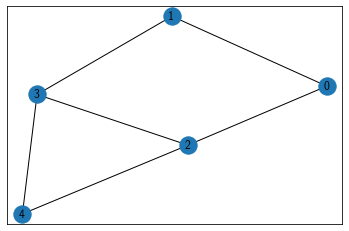

In [2]:
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,2.0),(2,3,1.5),(3,1,1.1),(3,4,0.4),(4,2,1.0)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
nx.draw_networkx(G,pos=pos)
k_cuts=2

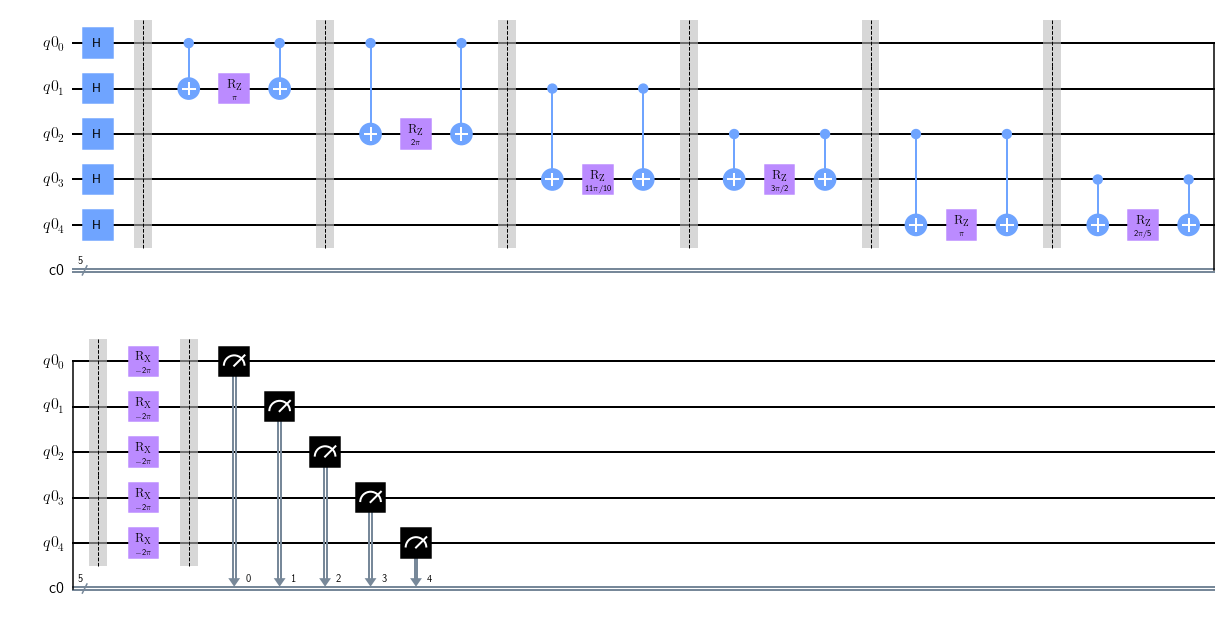

In [3]:
depth=1
createCircuit_MaxCut(np.array((np.pi,np.pi)),G,depth,k_cuts,1,True,"depth1").draw(output='mpl')

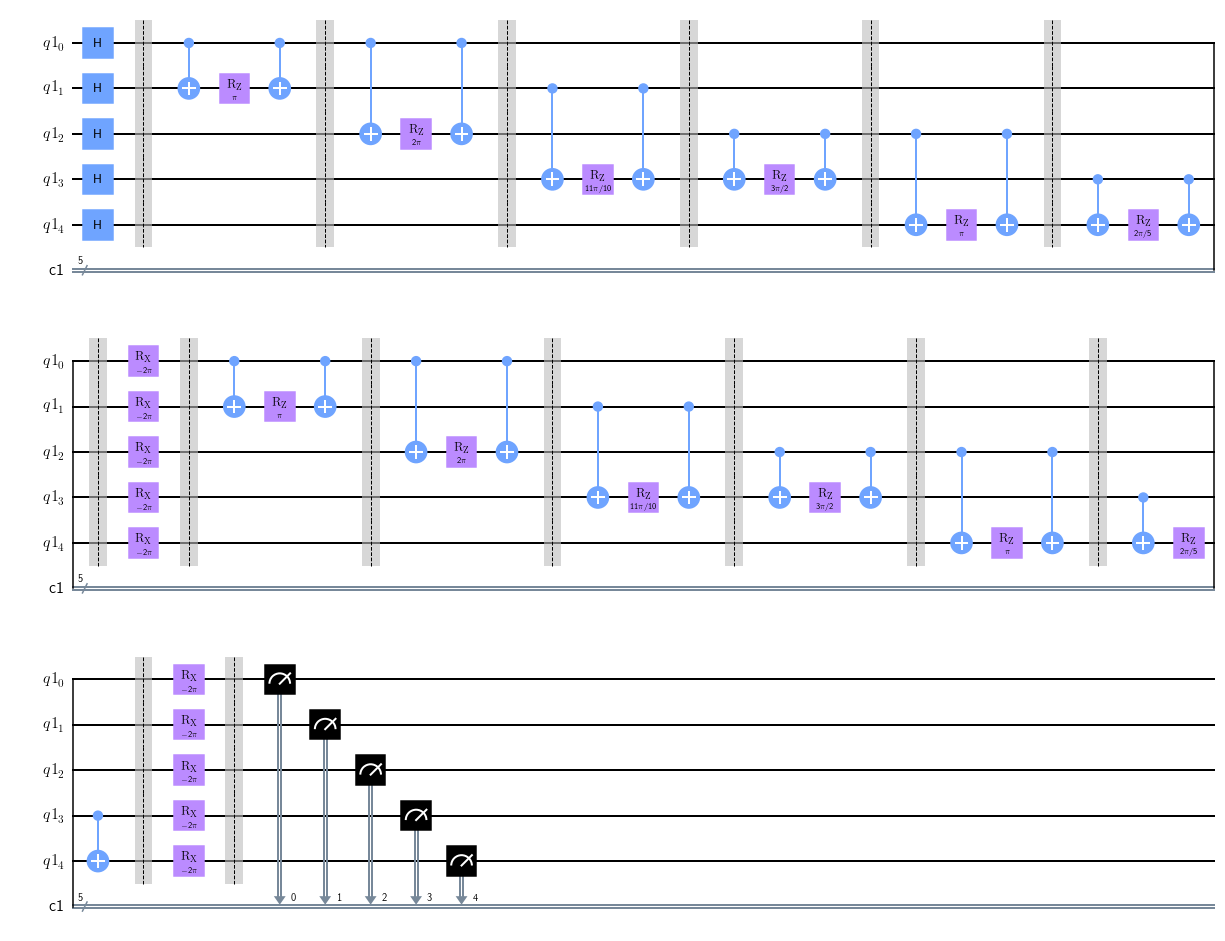

In [4]:
depth=2
createCircuit_MaxCut(np.array((np.pi,np.pi,np.pi,np.pi)),G,depth,k_cuts,1,True,"depth2").draw(output='mpl')

In [5]:
costs=listSortedCosts_MaxCut(G,2)
costs

{'00000': 0,
 '11111': 0,
 '00001': 1.4,
 '11110': 1.4,
 '01000': 2.1,
 '10111': 2.1,
 '01010': 2.9,
 '10101': 2.9,
 '00010': 3.0,
 '01111': 3.0,
 '10000': 3.0,
 '11101': 3.0,
 '00111': 3.1,
 '11000': 3.1,
 '01001': 3.5,
 '01011': 3.5,
 '10100': 3.5,
 '10110': 3.5,
 '00011': 3.6,
 '11100': 3.6,
 '00101': 3.9,
 '11010': 3.9,
 '01110': 4.4,
 '10001': 4.4,
 '00100': 4.5,
 '00110': 4.5,
 '11001': 4.5,
 '11011': 4.5,
 '01101': 6.0,
 '10010': 6.0,
 '01100': 6.6,
 '10011': 6.6}

In [6]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

Text(0, 0.5, '$\\beta$')

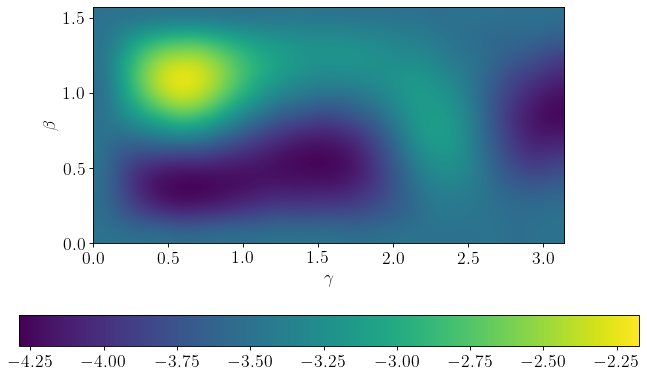

In [7]:
n=12
m=24
beta_max=np.pi/2
gamma_max=np.pi

circuits=[]
for beta in np.linspace(0,beta_max,n):
    for gamma in np.linspace(0,gamma_max,m):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,2,1))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v1,_,_ = measurementStatistics_MaxCut(job_sim.result().results, options={'G' : G, 'k_cuts' : k_cuts})
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(-np.array(Elandscape_v1).reshape(n,m),interpolation='bicubic',origin='lower',extent=[0,gamma_max,0,beta_max])
pl.colorbar(orientation="horizontal", pad=0.2)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')

In [8]:
from scipy import optimize as opt

In [9]:
def getval(x, backend, depth=1, version=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth,k_cuts,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val,_,_=measurementStatistics_MaxCut(j.result().results, options={'G' : G, 'k_cuts' : k_cuts})
    global it, values, gamma, beta
    #print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

Optimization terminated successfully.
         Current function value: -4.255823
         Iterations: 16
         Function evaluations: 36
[1.08783264 0.42189941]


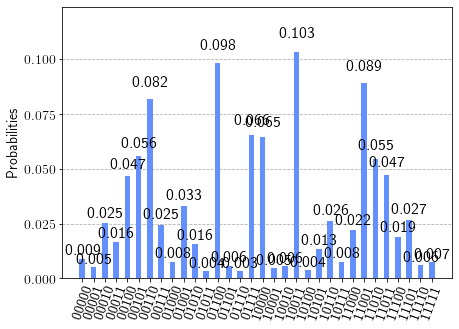

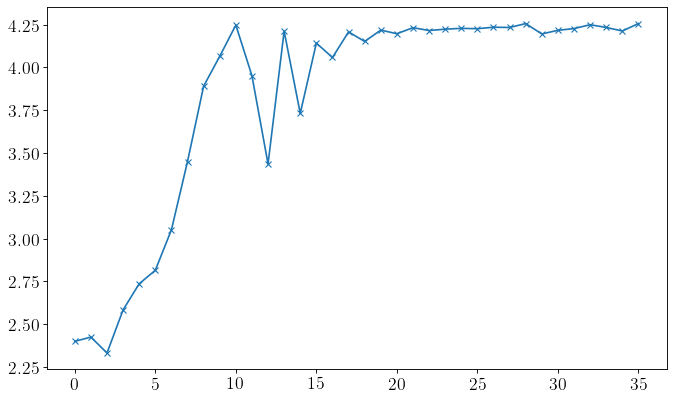

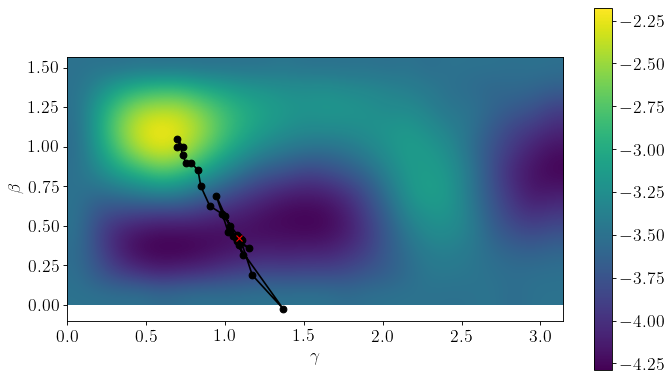

In [10]:
version=1
it=0
gamma={}
beta={}
values={}
out=opt.minimize(getval, x0=(.7,1), method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})
print(out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(-np.array(Elandscape_v1).reshape(n,m),interpolation='bicubic',origin='lower',extent=[0,gamma_max,0,beta_max])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')

j = execute(createCircuit_MaxCut(out.x,G,1,k_cuts,version), backend_sim, shots=1024*2*2*2)
plot_histogram(j.result().get_counts())